In [15]:
#Basic libraries
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

#Framework
import torch
import torchvision

#data and its management related libraries
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import datasets, models
import torchvision.transforms as transforms
from PIL import Image #python imaging library
import cv2

#for creating neural networks
import torch.nn as nn
import torch.nn.functional as F

#for optimising neural networks
import torch.optim as optim

#for metrics and analysis
import sklearn
from torchsummary import summary

# for dataset loading
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [16]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device in Use:",device)

Device in Use: cpu


In [17]:
torch.manual_seed(42) # Setting the seed

In [18]:
california= fetch_california_housing();

X = california.data
y = california.target

# Convert to pandas DataFrame for easier manipulation
columns = california.feature_names + ['MedHouseVal']
df = pd.DataFrame(data=np.c_[X, y], columns=columns)

# Preview the first few rows of the DataFrame
print(df.head())

# splitting X and y into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.422  


In [19]:
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print("\nAfter Standardization:")
print(X_train_scaled[:3])

# Convert the scaled arrays back to pandas DataFrame
X_train_scaled_df = pd.DataFrame(data=X_train_scaled, columns=california.feature_names)
X_val_scaled_df = pd.DataFrame(data=X_val_scaled, columns=california.feature_names)

# Preview the scaled training data
print(X_val_scaled_df.head())


After Standardization:
[[-0.326196    0.34849025 -0.17491646 -0.20836543  0.76827628  0.05137609
  -1.3728112   1.27258656]
 [-0.03584338  1.61811813 -0.40283542 -0.12853018 -0.09890135 -0.11736222
  -0.87669601  0.70916212]
 [ 0.14470145 -1.95271028  0.08821601 -0.25753771 -0.44981806 -0.03227969
  -0.46014647 -0.44760309]]
     MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0 -1.155085 -0.286324 -0.520686  -0.171746   -0.030301  0.067408  0.195100   
1 -0.708659  0.110435 -0.165815   0.223472    0.121851 -0.036030 -0.235491   
2 -0.210402  1.856173 -0.610765   0.205892   -0.102419 -0.149989  1.009478   
3  0.975113 -0.921138  0.305115  -0.176552    0.244979  0.030011 -0.637999   
4 -0.081794  0.427842  0.024193  -0.158465   -0.319653 -0.052971  0.457199   

   Longitude  
0   0.285347  
1   0.060975  
2  -1.424870  
3   0.429943  
4  -1.170581  


In [20]:
# Convert to torch tensors
X_train_torch = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Reshape for consistency in dimensions
X_val_torch = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_torch = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

print("\nAfter Converting to Torch Tensor:")
print(X_train_torch.shape, y_train_torch.shape)
print(X_train_torch[:3])
print(y_train_torch[:3])


After Converting to Torch Tensor:
torch.Size([16512, 8]) torch.Size([16512, 1])
tensor([[-0.3262,  0.3485, -0.1749, -0.2084,  0.7683,  0.0514, -1.3728,  1.2726],
        [-0.0358,  1.6181, -0.4028, -0.1285, -0.0989, -0.1174, -0.8767,  0.7092],
        [ 0.1447, -1.9527,  0.0882, -0.2575, -0.4498, -0.0323, -0.4601, -0.4476]])
tensor([[1.0300],
        [3.8210],
        [1.7260]])


In [21]:
# Create TensorDatasets for training and testing data
train_dataset = TensorDataset(X_train_torch, y_train_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)

# Define batch size
batch_size = 32

# Create DataLoaders for training and testing data
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valoader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [22]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(in_features=X_train.shape[1], out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=32)
        self.fc4 = nn.Linear(in_features=32, out_features=1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [23]:
class Adam:
 def __init__(self, model, lr=0.0001, beta1=0.9, beta2=0.999, epsilon=1e-8):

  self. model=model
  self.mt=[torch.zeros_like(p) for p in model.parameters()]
  self.vt=[torch.zeros_like(p) for p in model.parameters()]
  self.t=0
  self.beta1=beta1
  self.beta2=beta2
  self.lr=lr
  self.epsilon=epsilon

 def zero_grad(self):
  for p in self.model.parameters():
    if p.grad is not None:
      p.grad=torch.zeros_like(p.grad)

 def step(self):

  self.t+=1
  self.mt=[self.beta1*m+(1-self.beta1)*p.grad for p,m in zip(model.parameters(),self.mt)]
  self.vt=[self.beta2*v+(1-self.beta2)*p.grad**2 for p,v in zip(model.parameters(),self.vt)]
  m_hat_t=[m/(1-self.beta1**self.t)for m in self.mt]
  v_hat_t=[m/(1-self.beta2**self.t)for m in self.vt]

  for p,m,v in zip(model.parameters(),m_hat_t,v_hat_t):
    p.data=p.data-self.lr*m/(v.sqrt()+self.epsilon)



In [24]:
model = NeuralNetwork()
criterion = nn.MSELoss()
num_epochs=100

In [25]:
optimizer1=Adam(model)

In [26]:
criterion = nn.MSELoss()

# Define the number of epochs
num_epochs = 100

# Lists to store training and validation losses for plotting
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for inputs, targets in trainloader:
        # Zero the gradients
        optimizer1.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, targets)

        # Backward pass
        loss.backward()

        # Update parameters using Adam optimizer
        optimizer1.step()

        # Update training loss
        train_loss += loss.item() * inputs.size(0)

    # Compute average training loss for the epoch
    train_loss /= len(X_train)
    train_losses.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0

    for inputs, targets in valoader :
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        val_loss += loss.item() * inputs.size(0)

    # Compute average validation loss for the epoch
    val_loss /= len(X_val)
    val_losses.append(val_loss)

    # Print the loss for every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')


Epoch [1/100], Train Loss: 2.4375, Val Loss: 0.9239
Epoch [2/100], Train Loss: 0.7923, Val Loss: 0.6658
Epoch [3/100], Train Loss: 0.5987, Val Loss: 0.5539
Epoch [4/100], Train Loss: 0.5031, Val Loss: 0.4939
Epoch [5/100], Train Loss: 0.4585, Val Loss: 0.4655
Epoch [6/100], Train Loss: 0.4351, Val Loss: 0.4435
Epoch [7/100], Train Loss: 0.4204, Val Loss: 0.4282
Epoch [8/100], Train Loss: 0.4078, Val Loss: 0.4129
Epoch [9/100], Train Loss: 0.3972, Val Loss: 0.4022
Epoch [10/100], Train Loss: 0.3874, Val Loss: 0.3946
Epoch [11/100], Train Loss: 0.3797, Val Loss: 0.3846
Epoch [12/100], Train Loss: 0.3724, Val Loss: 0.3789
Epoch [13/100], Train Loss: 0.3657, Val Loss: 0.3783
Epoch [14/100], Train Loss: 0.3605, Val Loss: 0.3663
Epoch [15/100], Train Loss: 0.3553, Val Loss: 0.3636
Epoch [16/100], Train Loss: 0.3518, Val Loss: 0.3591
Epoch [17/100], Train Loss: 0.3467, Val Loss: 0.3544
Epoch [18/100], Train Loss: 0.3428, Val Loss: 0.3537
Epoch [19/100], Train Loss: 0.3390, Val Loss: 0.3480
Ep

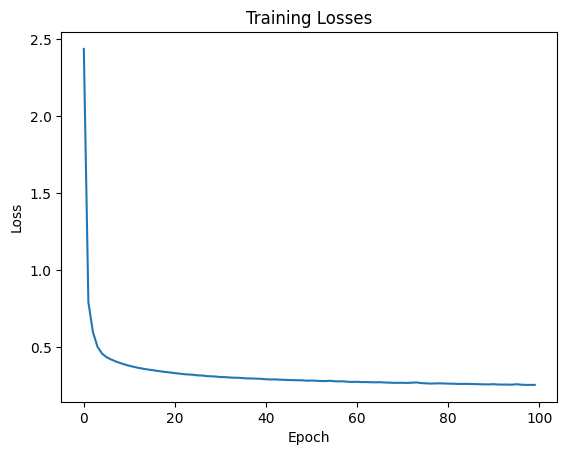

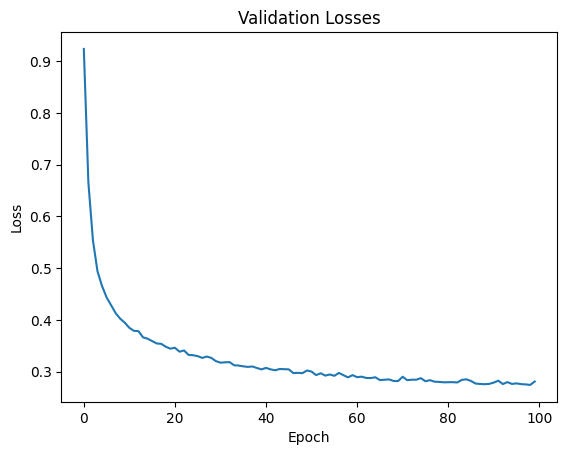

In [27]:
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.show()

plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Losses')
plt.show()

In [28]:
class NesterovAcceleratedGradient:
    def __init__(self, model, lr=0.001, momentum=0.9):
        self.model = model
        self.lr = lr
        self.momentum = momentum
        self.velocities = [torch.zeros_like(param, requires_grad=False) for param in model.parameters()]

    def step(self, inputs, targets):
        self.model.train()
        outputs = self.model(inputs)
        loss = criterion(outputs, targets)

        # Zero gradients
        self.model.zero_grad()

        # Compute gradients
        loss.backward()

        # Updating parameters using Nesterov Accelerated Gradient
        for param, velocity in zip(self.model.parameters(), self.velocities):
            # Saving the current parameters before the update
            param_prev = param.clone().detach()

            # Updating parameters with momentum
            velocity *= self.momentum
            param.data += velocity

            # Computing gradients at the lookahead position
            outputs = self.model(inputs)
            lookahead_loss = criterion(outputs, targets)
            lookahead_loss.backward()

            velocity += self.lr * param.grad

            param.data = param_prev - self.lr * velocity

    def zero_grad(self):
        # Reset gradients
        for velocity in self.velocities:
            velocity.zero_()

optimizer2 = NesterovAcceleratedGradient(model)


In [29]:
model = NeuralNetwork()
# Lists to store training and validation losses for plotting
train_losses_nag = []
val_losses_nag = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss_nag = 0.0

    for inputs, targets in trainloader:
        optimizer2.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()

        optimizer2.step(inputs,targets)

        # Update training loss
        train_loss_nag += loss.item() * inputs.size(0)

    # Compute average training loss for the epoch
    train_loss_nag /= len(X_train)
    train_losses_nag.append(train_loss_nag)

    # Validation loop
    model.eval()
    val_loss_nag= 0.0

    for inputs, targets in valoader :
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        val_loss_nag += loss.item() * inputs.size(0)

    # Compute average validation loss for the epoch
    val_loss_nag /= len(X_val)
    val_losses_nag.append(val_loss_nag)

    # Print the loss for every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss_nag:.4f}, Val Loss: {val_loss_nag:.4f}')


Epoch [1/100], Train Loss: 6.0629, Val Loss: 5.9662
Epoch [2/100], Train Loss: 6.0629, Val Loss: 5.9662
Epoch [3/100], Train Loss: 6.0629, Val Loss: 5.9662
Epoch [4/100], Train Loss: 6.0629, Val Loss: 5.9662
Epoch [5/100], Train Loss: 6.0629, Val Loss: 5.9662
Epoch [6/100], Train Loss: 6.0629, Val Loss: 5.9662
Epoch [7/100], Train Loss: 6.0629, Val Loss: 5.9662
Epoch [8/100], Train Loss: 6.0629, Val Loss: 5.9662
Epoch [9/100], Train Loss: 6.0629, Val Loss: 5.9662
Epoch [10/100], Train Loss: 6.0629, Val Loss: 5.9662
Epoch [11/100], Train Loss: 6.0629, Val Loss: 5.9662
Epoch [12/100], Train Loss: 6.0629, Val Loss: 5.9662
Epoch [13/100], Train Loss: 6.0629, Val Loss: 5.9662
Epoch [14/100], Train Loss: 6.0629, Val Loss: 5.9662
Epoch [15/100], Train Loss: 6.0629, Val Loss: 5.9662
Epoch [16/100], Train Loss: 6.0629, Val Loss: 5.9662
Epoch [17/100], Train Loss: 6.0629, Val Loss: 5.9662
Epoch [18/100], Train Loss: 6.0629, Val Loss: 5.9662
Epoch [19/100], Train Loss: 6.0629, Val Loss: 5.9662
Ep

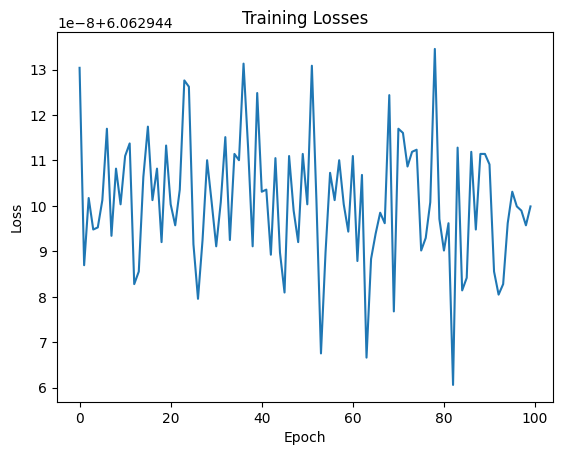

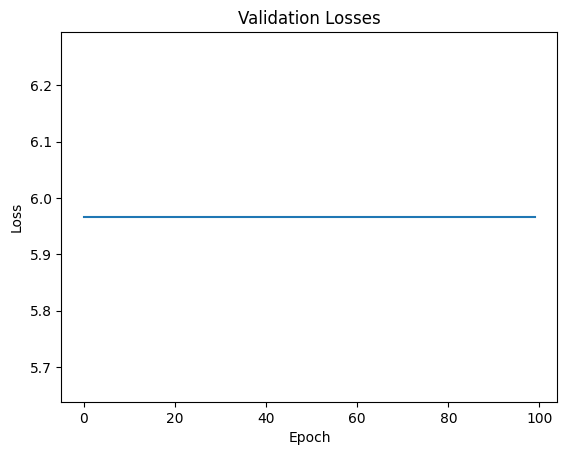

In [39]:
plt.plot(train_losses_nag, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.show()

plt.plot(val_losses_nag, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Losses')
plt.show()

Using inbuild optimizers

In [40]:
model = NeuralNetwork()
optimizer=optim.Adam(model.parameters(),lr=0.001)
criterion = nn.MSELoss()

# Define the number of epochs
num_epochs = 100

# Lists to store training and validation losses for plotting
train_losses_adam = []
val_losses_adam = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for inputs, targets in trainloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()

        optimizer.step()

        # Update training loss
        train_loss += loss.item() * inputs.size(0)

    # Compute average training loss for the epoch
    train_loss /= len(X_train)
    train_losses_adam.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0

    for inputs, targets in valoader :
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        val_loss += loss.item() * inputs.size(0)

    # Compute average validation loss for the epoch
    val_loss /= len(X_val)
    val_losses_adam.append(val_loss)

    # Print the loss for every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Epoch [1/100], Train Loss: 0.8655, Val Loss: 0.4219
Epoch [2/100], Train Loss: 0.3979, Val Loss: 0.3871
Epoch [3/100], Train Loss: 0.3636, Val Loss: 0.3629
Epoch [4/100], Train Loss: 0.3483, Val Loss: 0.3498
Epoch [5/100], Train Loss: 0.3355, Val Loss: 0.3325
Epoch [6/100], Train Loss: 0.3210, Val Loss: 0.3200
Epoch [7/100], Train Loss: 0.3093, Val Loss: 0.3079
Epoch [8/100], Train Loss: 0.3030, Val Loss: 0.3061
Epoch [9/100], Train Loss: 0.3007, Val Loss: 0.3134
Epoch [10/100], Train Loss: 0.2926, Val Loss: 0.3268
Epoch [11/100], Train Loss: 0.2884, Val Loss: 0.2973
Epoch [12/100], Train Loss: 0.2851, Val Loss: 0.2906
Epoch [13/100], Train Loss: 0.2851, Val Loss: 0.2835
Epoch [14/100], Train Loss: 0.2806, Val Loss: 0.2830
Epoch [15/100], Train Loss: 0.2796, Val Loss: 0.2822
Epoch [16/100], Train Loss: 0.2720, Val Loss: 0.2821
Epoch [17/100], Train Loss: 0.2719, Val Loss: 0.2816
Epoch [18/100], Train Loss: 0.2693, Val Loss: 0.2919
Epoch [19/100], Train Loss: 0.2692, Val Loss: 0.3152
Ep

In [42]:
model = NeuralNetwork()
optimizer=optim.SGD(model.parameters(),lr=0.001,momentum=0.9, nesterov=True)
criterion = nn.MSELoss()

# Define the number of epochs
num_epochs = 100

# Lists to store training and validation losses for plotting
train_losses_NAG = []
val_losses_NAG = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for inputs, targets in trainloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()

        optimizer.step()

        # Update training loss
        train_loss += loss.item() * inputs.size(0)

    # Compute average training loss for the epoch
    train_loss /= len(X_train)
    train_losses_NAG.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0

    for inputs, targets in valoader :
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        val_loss += loss.item() * inputs.size(0)

    # Compute average validation loss for the epoch
    val_loss /= len(X_val)
    val_losses_NAG.append(val_loss)

    # Print the loss for every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Epoch [1/100], Train Loss: 0.9154, Val Loss: 0.4753
Epoch [2/100], Train Loss: 0.4285, Val Loss: 0.4222
Epoch [3/100], Train Loss: 0.3950, Val Loss: 0.3928
Epoch [4/100], Train Loss: 0.3763, Val Loss: 0.3787
Epoch [5/100], Train Loss: 0.3616, Val Loss: 0.3621
Epoch [6/100], Train Loss: 0.3529, Val Loss: 0.3584
Epoch [7/100], Train Loss: 0.3520, Val Loss: 0.3450
Epoch [8/100], Train Loss: 0.3360, Val Loss: 0.3383
Epoch [9/100], Train Loss: 0.3288, Val Loss: 0.3414
Epoch [10/100], Train Loss: 0.3245, Val Loss: 0.3290
Epoch [11/100], Train Loss: 0.3177, Val Loss: 0.3236
Epoch [12/100], Train Loss: 0.3158, Val Loss: 0.3272
Epoch [13/100], Train Loss: 0.3107, Val Loss: 0.3158
Epoch [14/100], Train Loss: 0.3082, Val Loss: 0.3118
Epoch [15/100], Train Loss: 0.3058, Val Loss: 0.3069
Epoch [16/100], Train Loss: 0.3015, Val Loss: 0.3059
Epoch [17/100], Train Loss: 0.2979, Val Loss: 0.3098
Epoch [18/100], Train Loss: 0.2959, Val Loss: 0.3119
Epoch [19/100], Train Loss: 0.2950, Val Loss: 0.3050
Ep

In [47]:
model = NeuralNetwork()
optimizer=optim.Adagrad(model.parameters(),lr=0.001)
criterion = nn.MSELoss()

# Define the number of epochs
num_epochs = 100

# Lists to store training and validation losses for plotting
train_losses_adagrad = []
val_losses_adagrad = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for inputs, targets in trainloader:

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    # Compute average training loss for the epoch
    train_loss /= len(X_train)
    train_losses_adagrad.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0

    for inputs, targets in valoader :
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        val_loss += loss.item() * inputs.size(0)

    # Compute average validation loss for the epoch
    val_loss /= len(X_val)
    val_losses_adagrad.append(val_loss)

    # Print the loss for every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Epoch [1/100], Train Loss: 1.8509, Val Loss: 1.0137
Epoch [2/100], Train Loss: 1.0542, Val Loss: 0.8134
Epoch [3/100], Train Loss: 0.8922, Val Loss: 0.7258
Epoch [4/100], Train Loss: 0.8015, Val Loss: 0.6755
Epoch [5/100], Train Loss: 0.7405, Val Loss: 0.6392
Epoch [6/100], Train Loss: 0.6911, Val Loss: 0.6121
Epoch [7/100], Train Loss: 0.6524, Val Loss: 0.5900
Epoch [8/100], Train Loss: 0.6203, Val Loss: 0.5712
Epoch [9/100], Train Loss: 0.5915, Val Loss: 0.5548
Epoch [10/100], Train Loss: 0.5677, Val Loss: 0.5413
Epoch [11/100], Train Loss: 0.5482, Val Loss: 0.5295
Epoch [12/100], Train Loss: 0.5318, Val Loss: 0.5194
Epoch [13/100], Train Loss: 0.5176, Val Loss: 0.5110
Epoch [14/100], Train Loss: 0.5057, Val Loss: 0.5029
Epoch [15/100], Train Loss: 0.4952, Val Loss: 0.4960
Epoch [16/100], Train Loss: 0.4863, Val Loss: 0.4898
Epoch [17/100], Train Loss: 0.4785, Val Loss: 0.4842
Epoch [18/100], Train Loss: 0.4717, Val Loss: 0.4793
Epoch [19/100], Train Loss: 0.4657, Val Loss: 0.4747
Ep

In [41]:
model=NeuralNetwork()
optimizer=optim.Adadelta(model.parameters(),lr=0.001)
criterion = nn.MSELoss()

# Define the number of epochs
num_epochs = 100

# Lists to store training and validation losses for plotting
train_losses_adadelta = []
val_losses_adadelta = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for inputs, targets in trainloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()

        # Update parameters using Adam optimizer
        optimizer.step()

        # Update training loss
        train_loss += loss.item() * inputs.size(0)

    # Compute average training loss for the epoch
    train_loss /= len(X_train)
    train_losses_adadelta.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0

    for inputs, targets in valoader :
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        val_loss += loss.item() * inputs.size(0)

    # Compute average validation loss for the epoch
    val_loss /= len(X_val)
    val_losses_adadelta.append(val_loss)

    # Print the loss for every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Epoch [1/100], Train Loss: 0.1684, Val Loss: 0.2479
Epoch [2/100], Train Loss: 0.1665, Val Loss: 0.2468
Epoch [3/100], Train Loss: 0.1650, Val Loss: 0.2459
Epoch [4/100], Train Loss: 0.1638, Val Loss: 0.2453
Epoch [5/100], Train Loss: 0.1628, Val Loss: 0.2449
Epoch [6/100], Train Loss: 0.1620, Val Loss: 0.2445
Epoch [7/100], Train Loss: 0.1614, Val Loss: 0.2443
Epoch [8/100], Train Loss: 0.1608, Val Loss: 0.2441
Epoch [9/100], Train Loss: 0.1603, Val Loss: 0.2440
Epoch [10/100], Train Loss: 0.1598, Val Loss: 0.2439
Epoch [11/100], Train Loss: 0.1594, Val Loss: 0.2438
Epoch [12/100], Train Loss: 0.1590, Val Loss: 0.2437
Epoch [13/100], Train Loss: 0.1587, Val Loss: 0.2437
Epoch [14/100], Train Loss: 0.1584, Val Loss: 0.2436
Epoch [15/100], Train Loss: 0.1581, Val Loss: 0.2436
Epoch [16/100], Train Loss: 0.1578, Val Loss: 0.2435
Epoch [17/100], Train Loss: 0.1576, Val Loss: 0.2435
Epoch [18/100], Train Loss: 0.1574, Val Loss: 0.2435
Epoch [19/100], Train Loss: 0.1571, Val Loss: 0.2434
Ep

In [49]:
model=NeuralNetwork()
optimizer=optim.Adamax(model.parameters(),lr=0.001)
criterion = nn.MSELoss()

# Define the number of epochs
num_epochs = 100

# Lists to store training and validation losses for plotting
train_losses_adamax= []
val_losses_adamax = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for inputs, targets in trainloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()

        # Update parameters using Adam optimizer
        optimizer.step()

        # Update training loss
        train_loss += loss.item() * inputs.size(0)

    # Compute average training loss for the epoch
    train_loss /= len(X_train)
    train_losses_adamax.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0

    for inputs, targets in valoader :
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        val_loss += loss.item() * inputs.size(0)

    # Compute average validation loss for the epoch
    val_loss /= len(X_val)
    val_losses_adamax.append(val_loss)

    # Print the loss for every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Epoch [1/100], Train Loss: 1.3888, Val Loss: 0.6743
Epoch [2/100], Train Loss: 0.6704, Val Loss: 0.5212
Epoch [3/100], Train Loss: 0.5346, Val Loss: 0.4611
Epoch [4/100], Train Loss: 0.4640, Val Loss: 0.4262
Epoch [5/100], Train Loss: 0.4208, Val Loss: 0.4027
Epoch [6/100], Train Loss: 0.3907, Val Loss: 0.3847
Epoch [7/100], Train Loss: 0.3731, Val Loss: 0.3720
Epoch [8/100], Train Loss: 0.3605, Val Loss: 0.3623
Epoch [9/100], Train Loss: 0.3512, Val Loss: 0.3566
Epoch [10/100], Train Loss: 0.3424, Val Loss: 0.3551
Epoch [11/100], Train Loss: 0.3340, Val Loss: 0.3419
Epoch [12/100], Train Loss: 0.3259, Val Loss: 0.3287
Epoch [13/100], Train Loss: 0.3200, Val Loss: 0.3264
Epoch [14/100], Train Loss: 0.3148, Val Loss: 0.3196
Epoch [15/100], Train Loss: 0.3099, Val Loss: 0.3130
Epoch [16/100], Train Loss: 0.3049, Val Loss: 0.3149
Epoch [17/100], Train Loss: 0.3008, Val Loss: 0.3068
Epoch [18/100], Train Loss: 0.2974, Val Loss: 0.3110
Epoch [19/100], Train Loss: 0.2934, Val Loss: 0.3009
Ep

In [43]:
model=NeuralNetwork()
optimizer=optim.SGD(model.parameters(),lr=0.001)
criterion = nn.MSELoss()

# Define the number of epochs
num_epochs = 100

# Lists to store training and validation losses for plotting
train_losses_v = []
val_losses_v = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for inputs, targets in trainloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()

        # Update parameters using Adam optimizer
        optimizer.step()

        # Update training loss
        train_loss += loss.item() * inputs.size(0)

    # Compute average training loss for the epoch
    train_loss /= len(X_train)
    train_losses_v.append(train_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0

    for inputs, targets in valoader :
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        val_loss += loss.item() * inputs.size(0)

    # Compute average validation loss for the epoch
    val_loss /= len(X_val)
    val_losses_v.append(val_loss)

    # Print the loss for every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Epoch [1/100], Train Loss: 2.0085, Val Loss: 0.8720
Epoch [2/100], Train Loss: 0.6860, Val Loss: 0.6248
Epoch [3/100], Train Loss: 0.5841, Val Loss: 0.5794
Epoch [4/100], Train Loss: 0.5463, Val Loss: 0.5484
Epoch [5/100], Train Loss: 0.5184, Val Loss: 0.5259
Epoch [6/100], Train Loss: 0.4966, Val Loss: 0.5064
Epoch [7/100], Train Loss: 0.4798, Val Loss: 0.4902
Epoch [8/100], Train Loss: 0.4666, Val Loss: 0.4795
Epoch [9/100], Train Loss: 0.4560, Val Loss: 0.4696
Epoch [10/100], Train Loss: 0.4469, Val Loss: 0.4605
Epoch [11/100], Train Loss: 0.4393, Val Loss: 0.4559
Epoch [12/100], Train Loss: 0.4330, Val Loss: 0.4483
Epoch [13/100], Train Loss: 0.4273, Val Loss: 0.4421
Epoch [14/100], Train Loss: 0.4226, Val Loss: 0.4351
Epoch [15/100], Train Loss: 0.4179, Val Loss: 0.4318
Epoch [16/100], Train Loss: 0.4137, Val Loss: 0.4288
Epoch [17/100], Train Loss: 0.4098, Val Loss: 0.4233
Epoch [18/100], Train Loss: 0.4062, Val Loss: 0.4185
Epoch [19/100], Train Loss: 0.4028, Val Loss: 0.4161
Ep

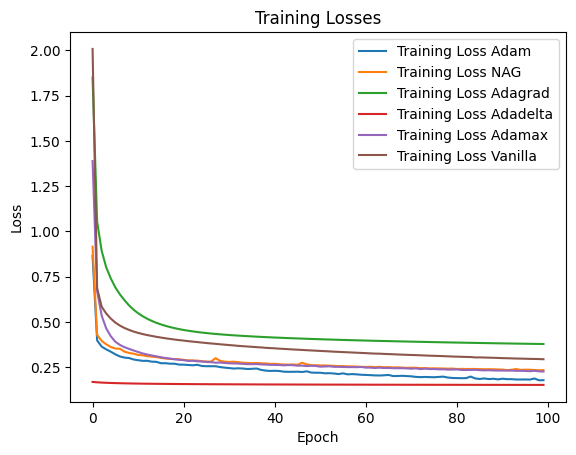

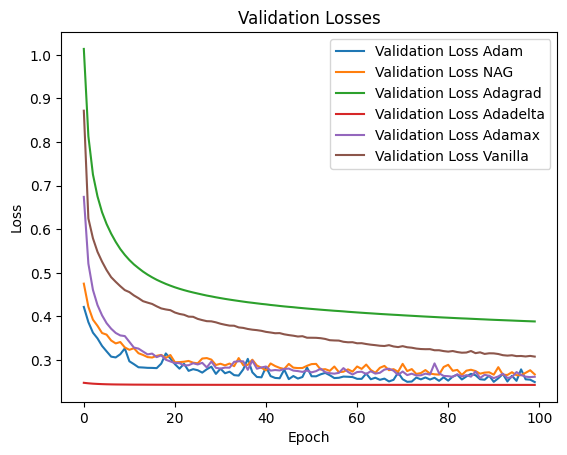

In [52]:
plt.plot(train_losses_adam, label='Training Loss Adam')
plt.plot(train_losses_NAG, label='Training Loss NAG')
plt.plot(train_losses_adagrad, label='Training Loss Adagrad')
plt.plot(train_losses_adadelta, label='Training Loss Adadelta')
plt.plot(train_losses_adamax, label='Training Loss Adamax')
plt.plot(train_losses_v, label='Training Loss Vanilla')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.show()

plt.plot(val_losses_adam, label='Validation Loss Adam')
plt.plot(val_losses_NAG, label='Validation Loss NAG')
plt.plot(val_losses_adagrad, label='Validation Loss Adagrad')
plt.plot(val_losses_adadelta, label='Validation Loss Adadelta')
plt.plot(val_losses_adamax, label='Validation Loss Adamax')
plt.plot(val_losses_v, label='Validation Loss Vanilla')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Losses')
plt.show()